# Diffusion model

We consider a Gaussian Mixture target 
\begin{equation}
    q_0 = \sum_{k=1}^K w_k \mathcal{N}(x; m_k, C_k)
\end{equation}
The forward process (OU process) 
\begin{align*}
	&dX_t = -X_t dt + \sqrt{2} dB_t, \qquad X_0  \sim q_0, \qquad 0 \leq t \leq T  \\
    &X_t \sim \lambda_t X_0 + \sigma_t W, \qquad W\sim N(0,I)
\end{align*}
with  $\lambda_t = e^{-t}$ and $\sigma_t = \sqrt{1 - e^{-2t}}$ gives
\begin{align*}
	q_t(y) = &  \int_{R^d} \frac{1}{(\sqrt{2\pi} \sigma_t)^d} \cdot \exp \left( -\frac{\|y - \lambda_t x\|_2^2}{2\sigma_t^2} \right) q_0(x) \mathrm{d} x \\
	= & \sum_{k=1}^K w_k \mathcal{N}(y; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)
\end{align*}

The score function is 
\begin{align*}
	\nabla_x \log q_t(x)
	= & -\sum_{k=1}^K\frac{w_k\mathcal{N}(x; \lambda_t m_k, \lambda_t^2 C_k + \sigma_t^2 I)}{q_t(x)} (\lambda_t^2C_k + \sigma_t^2I)^{-1}(x - \lambda_t m_k)
\end{align*}




In [25]:
using PyPlot
using LinearAlgebra
using Random 
using Distributions
using KernelDensity 
using NPZ

"""
    Gaussian_density(x_mean::Array{FT,1}, xx_cov, x::Array{FT,1}; propto::Bool=true, xx_prec=nothing, det_xx_cov=nothing) where {FT<:AbstractFloat}

Compute the multivariate Gaussian density at point `x`, given mean `x_mean` and covariance matrix `xx_cov`.

# Arguments
- `x_mean::Array{FT,1}`: Mean vector of the Gaussian distribution.
- `xx_cov`: Covariance matrix (can be any matrix type compatible with `\` and `det`).
- `x::Array{FT,1}`: Point at which the density is evaluated.
- `propto::Bool=true`: If `true`, omit constant normalization factor `(2π)^(d/2)`.
- `xx_prec`: Optional precision matrix (inverse of `xx_cov`). If not provided, it is computed implicitly via backslash operator.
- `det_xx_cov`: Optional determinant of `xx_cov`. If not provided, it is computed using `det(xx_cov)`.

# Returns
- Scalar value: the (possibly unnormalized) Gaussian density at `x`.

# Notes
- To avoid redundant computations, `xx_prec` and `det_xx_cov` can be precomputed and passed as arguments.
- For large-scale problems, consider using more numerically stable methods for computing the log-density.
"""
function Gaussian_density(x_mean::Array{FT,1}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_x = size(x_mean,1)
    if det_xx_cov === nothing
        det_xx_cov = det(xx_cov)
    end
    Cinv_x =  (xx_prec === nothing ? xx_cov\(x - x_mean) : xx_prec*(x - x_mean))
        
    Z = (propto ? sqrt(det_xx_cov) : (2π)^(N_x/2)*sqrt(det_xx_cov))
    return exp( -1/2*((x - x_mean)'* Cinv_x)) / Z

end


"""
    Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; 
                             propto::Bool=true, xx_prec=nothing, det_xx_cov=nothing) 
                             where {FT<:AbstractFloat}

Compute the (possibly unnormalized) density of a Gaussian mixture model (GMM) at a point `x`.

# Arguments
- `x_w::Array{FT,1}`: Weights for each Gaussian component (should sum to 1 for a valid GMM).
- `x_mean::Array{FT,2}`: A matrix where each row is the mean of a Gaussian component (size: N_modes × dim).
- `xx_cov`: A collection (e.g., vector of matrices) of covariance matrices, one per component.
- `x::Array{FT,1}`: The point at which the density is evaluated.
- `propto::Bool=true`: Whether to omit the `(2π)^(d/2)` constant in the density.
- `xx_prec`: Optional precomputed precision matrices (inverse of covariances).
- `det_xx_cov`: Optional precomputed determinants of covariance matrices.

# Returns
- Scalar value: the (possibly unnormalized) mixture density at point `x`.

# Notes
- Precomputing precision and determinant arrays can improve performance.
"""
function Gaussian_mixture_density(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; propto::Bool= true, xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    ρ = 0.0
    N_modes, dim = size(x_mean)
    
    for i = 1:N_modes
        ρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = propto, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i]))
    end
    
    return ρ
end


"""
    Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; 
                                    xx_prec=nothing, det_xx_cov=nothing) 
                                    where {FT<:AbstractFloat}

Compute the score function (∇ log p(x)) of a Gaussian mixture model at a point `x`.

# Arguments
- `x_w::Array{FT,1}`: Mixture weights for each component.
- `x_mean::Array{FT,2}`: Matrix of component means, each row is one mean vector.
- `xx_cov`: Collection of covariance matrices.
- `x::Array{FT,1}`: Point at which to evaluate the score function.
- `xx_prec`: Optional precomputed precision matrices.
- `det_xx_cov`: Optional precomputed determinants of covariance matrices.

# Returns
- `∇logρ`: The gradient of the log-density at `x` (i.e., the score function).

# Notes
- This implementation assumes the score is with respect to `x`.
- Can be used in variational inference, diffusion models, and MCMC.
"""
function Gaussian_mixture_score_function(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, x::Array{FT,1}; xx_prec = nothing, det_xx_cov = nothing) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    ρ = Gaussian_mixture_density(x_w, x_mean, xx_cov, x; propto= true, xx_prec = xx_prec, det_xx_cov = det_xx_cov)
    ∇logρ = zeros(FT, dim)
    for i = 1:N_modes
        Cinv_x =  (xx_prec === nothing ? xx_cov[i]\(x_mean[i,:] - x) : xx_prec[i]*(x_mean[i,:] - x))
        
        ∇logρ += x_w[i]*Gaussian_density(x_mean[i,:], xx_cov[i], x; propto = true, 
        xx_prec = (xx_prec === nothing ? nothing : xx_prec[i]),
        det_xx_cov = (det_xx_cov === nothing ? nothing : det_xx_cov[i])) * Cinv_x
    end
    ∇logρ /= ρ
    
    return ∇logρ
end

Gaussian_mixture_score_function

To generate samples, we need to implement the backward process
\begin{align*}
    \partial_t \rho_t = -\nabla \cdot ((x + \nabla \log q_{T - t})\rho_t)    \qquad 0 \leq t \leq T
\end{align*}
which can be converted probability flow ODE
\begin{align*}
    dY_t =  Y_t + \nabla \log q_{T - t}(Y_t)  \qquad  Y_0 \sim N(0,I)   \qquad 0 \leq t \leq T
\end{align*}


In [26]:
"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process at time t.

Each Gaussian component (mean and covariance) is updated based on the diffusion dynamics:
    x(t) = λ_t * x(0) + σ_t * ε, with λ_t = exp(-t), σ_t = sqrt(1 - exp(-2t))

Arguments:
- x_w      : Weights of the Gaussian components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components (array of matrices).
- t        : Diffusion time.

Returns:
- x_mean_t : Updated means of the GMM components at time t.
- xx_cov_t : Updated covariances of the GMM components at time t.
"""
function compute_mt_covt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT) where {FT<:AbstractFloat}
    N_modes, N_x = size(x_mean)
    x_mean_t = copy(x_mean)
    xx_cov_t = []  
    λ_t , σ_t = exp(-t), sqrt(1 - exp(-2t))
    for i = 1:N_modes
        x_mean_t[i,:] = λ_t*x_mean[i,:]
        push!(xx_cov_t, λ_t^2*xx_cov[i] + σ_t^2*I)
    end
    return x_mean_t, xx_cov_t
end

"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the density q_t(x) at time t for a single sample x.

This evaluates the density of the time-evolved GMM at a given point x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- t        : Diffusion time.
- x        : A single point where the density is evaluated.

Returns:
- qt       : Value of q_t(x).
"""
function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, _ = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    qt = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, x; propto= false)
    return qt
end


"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the density q_t(x) at time t for a batch of samples xx.

Uses precomputed inverse covariances and determinants for efficient evaluation.

Arguments:
- x_w        : Weights of the GMM components.
- x_mean     : Means of the GMM components.
- xx_cov     : Covariances of the GMM components.
- t          : Diffusion time.
- xx         : Array of N samples (N x dim) to evaluate q_t at.

Returns:
- qt         : Array of q_t(x) values for each row in xx.
"""
function compute_qt(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    det_xx_cov_t = zeros(N_modes)
    xx_prec_t = []
    for im = 1:N_modes
        det_xx_cov_t[im] = det(xx_cov_t[im])
        push!(xx_prec_t, inv(xx_cov_t[im]))
    end
    
    qt = zeros(N_x)
    for i = 1:N_x
        qt[i] = Gaussian_mixture_density(x_w, x_mean_t, xx_cov_t, xx[i,:]; propto= false, det_xx_cov=det_xx_cov_t, xx_prec = xx_prec_t)
    end
    return qt
end

"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the score function ∇log q_t(x) at time t for a single sample x.

The score is the gradient of the log-density of the time-evolved GMM at x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- t        : Diffusion time.
- x        : A single sample.

Returns:
- ∇logqt   : Gradient of log q_t(x) with respect to x.
"""
function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, x::Array{FT,1}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    ∇logqt = Gaussian_mixture_score_function(x_w, x_mean_t, xx_cov_t, x) 
    return ∇logqt
end


"""
Propagate a Gaussian Mixture Model (GMM) through the forward diffusion process, 
and compute the score function ∇log q_t(x) at time t for a batch of samples xx.

The score is the gradient of the log-density of the time-evolved GMM at x.

Arguments:
- x_w      : Weights of the GMM components.
- x_mean   : Means of the GMM components.
- xx_cov   : Covariances of the GMM components.
- t        : Diffusion time.
- x        : A single sample.

Returns:
- ∇logqt   : Gradient of log q_t(x) with respect to x.
"""
function compute_qt_score(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    x_mean_t, xx_cov_t = compute_mt_covt(x_w, x_mean, xx_cov, t)
    
    sqrt_xx_prec_t = []
    det_sqrt_xx_prec_t = zeros(N_modes)
    for im = 1:N_modes
        
        push!(sqrt_xx_prec_t, inv(cholesky(xx_cov_t[im]).L))
        det_sqrt_xx_prec_t[im] = det(sqrt_xx_prec_t[im])
    end

    
    qt, ∇logqt = zeros(FT, N_x), zeros(FT, N_x, dim)

    for im in 1:N_modes
        x_p_demeaned = xx .- x_mean_t[im,:]'                                          
        norm_const = det_sqrt_xx_prec_t[im]                                         
        Cinv_x_p_demeaned =  x_p_demeaned * (sqrt_xx_prec_t[im]' * sqrt_xx_prec_t[im])
        
        ρt = x_w[im] * norm_const * exp.(-0.5 * vec(sum(Cinv_x_p_demeaned .* x_p_demeaned, dims=2)))   
        
        qt .+= ρt                      
        ∇logqt .-= Cinv_x_p_demeaned .* ρt
    end
    return ∇logqt ./ qt
end

"""
    compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, T::FT, xx::Union{Array{FT,1},Array{FT,2}})

Compute the drift term `U(t, x)` used in the reverse-time probability flow ODEs.
This function implements:
    U(t, x) = x + ∇log q_{T-t}(x)
where ∇log q_{T-t}(x) is the score of the Gaussian mixture at time (T - t).

# Arguments
- `x_w::Array{FT,1}`: Weights of each Gaussian component in the mixture.
- `x_mean::Array{FT,2}`: Means of each Gaussian component (size: N_modes × dim).
- `xx_cov`: Covariance matrices of the Gaussian components (vector of matrices).
- `t::FT`: Current time in the reverse diffusion process.
- `T::FT`: Total diffusion time (end of forward process).
- `xx::Union{Array{FT,1},Array{FT,2}}`: Points at which to evaluate the drift (size: N_x × dim or N_x).

# Returns
- `U(t, x)` evaluated at each point in `xx`, using the score of the time-reversed
  Gaussian mixture at time `T - t`.

"""
function compute_U_GM(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, t::FT, T::FT, xx::Union{Array{FT,1},Array{FT,2}}) where {FT<:AbstractFloat}
    xx = (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx)
    N_modes, dim = size(x_mean)
    N_x = size(xx, 1)
    ∇logqt = compute_qt_score(x_w, x_mean, xx_cov, T-t, xx)
    return xx + ∇logqt
end

compute_U_GM

We assume that we have access  to an imperfect score function characterized by the following artificial score errors $\delta(x) = s_{t}(x) - \nabla \log q_t(x)$

\begin{align*}
&\delta(x) = \frac{\tilde{\delta}(x[1])}{\sqrt{d}} 
\\
&\tilde{\delta}''(x) = \begin{cases} 1 & \lfloor{x\rfloor} = 2n  \\ -1 & \lfloor{x\rfloor} = 2n+1
\end{cases}\qquad
\tilde{\delta}'(x) = \begin{cases} x - \lfloor{x\rfloor} & \lfloor{x\rfloor} = 2n  \\ 
                                   1 + \lfloor{x\rfloor} - x & \lfloor{x\rfloor} = 2n+1
\end{cases}\qquad
\tilde{\delta}(x) = \begin{cases} n+\frac{(x - \lfloor{x\rfloor})^2}{2} & \lfloor{x\rfloor} = 2n  \\ n+1 - \frac{(1 + \lfloor{x\rfloor} -x)^2}{2} & \lfloor{x\rfloor} = 2n+1
\end{cases}
\end{align*}


In [27]:
"""
    score_error(x_w::Array{FT,1}, x_mean::Array{FT,2}, xx_cov, δ::FT, t::FT, T::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}

Add controlled perturbations (or noise) to the score function ∇log q_t(x) for experimental purposes.

# Arguments
- `x_w::Array{FT,1}`: Weights of the Gaussian mixture components.
- `x_mean::Array{FT,2}`: Means of the Gaussian components (N_modes × dim).
- `xx_cov`: Covariances of the Gaussian components (not used in this function but may be for extension).
- `δ::FT`: Magnitude of the perturbation (controls error scale).
- `t::FT`: Current time in the diffusion process (not used here, but included for extensibility).
- `T::FT`: Total diffusion time (also not used in this function).
- `xx::Array{FT,2}`: Input points at which the error is evaluated (N_x × dim).

# Returns
- An N_x × dim matrix containing the synthetic perturbation added to the score function.
"""
function score_error(δ::FT, xx::Array{FT,2}) where {FT<:AbstractFloat}

    N_x, dim = size(xx)
    xx1 = xx[:, 1]
    s1 = map(x1 -> begin 
            f = floor(Int, x1) 
            iseven(f) ? f/2 + (x1 - f)^2/2 : (f+1)/2 - (1 + f - x1)^2/2 
            end, xx1)

    ds =  δ/sqrt(dim) *  (s1  *ones(dim)')
    return ds
end

score_error

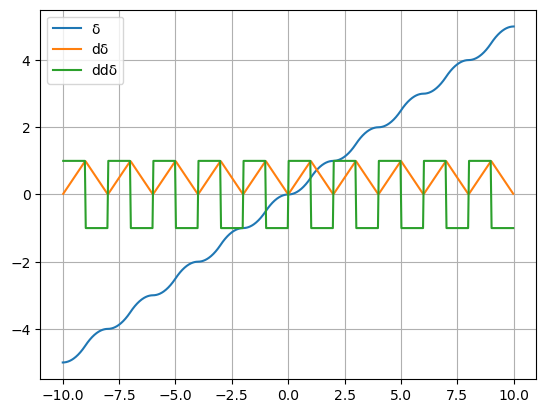

PyObject <matplotlib.legend.Legend object at 0x349b5bfa0>

In [28]:
x_l, x_r, Ne = -10, 10, 1000
Δx = (x_r - x_l) / Ne
xx1 = Array(LinRange(x_l, x_r, Ne + 1))
xx = reshape(xx1, (length(xx1), 1))
δ = score_error(1.0, xx)[:,1]
dδ = (δ[3:end] - δ[1:end-2])/(2*Δx)
ddδ = (δ[3:end] + δ[1:end-2] - 2δ[2:end-1])/(Δx^2)
fig, ax = PyPlot.subplots()
ax.plot(xx, δ, label="δ")
ax.grid("on")
plot(xx[2:end-1], dδ, label="dδ")
plot(xx[2:end-1], ddδ, label="ddδ")
ax.legend()

# Runge Kutta method

In [29]:
# First-order Runge-Kutta (Euler method) time update.
# Approximates the next state Y_n given the current state Y, time t, and timestep dt.
# compute_v is a function that returns the derivative at a given time and state.
function time_update_RK1(Y, t, dt, compute_v::Function)
    V = compute_v(t, Y)
    Y_n = Y + dt * V
    return Y_n
end

# Second-order Runge-Kutta (Heun's method) time update.
# Provides better accuracy than RK1 by taking an average of slopes.
function time_update_RK2(Y, t, dt, compute_v::Function)
    V1 = compute_v(t, Y)
    V2 = compute_v(t + dt, Y + dt * V1)
    Y_n = Y + 0.5 * dt * (V1 + V2)  # RK2 Update formula
    return Y_n
end

# Fourth-order Runge-Kutta (RK3) time update.
# Offers high accuracy by evaluating derivatives at multiple points.
function time_update_RK3(Y, t, dt, compute_v::Function)
    V1 = compute_v(t, Y)
    V2 = compute_v(t + 0.5 * dt, Y + 0.5 * dt * V1)
    V3 = compute_v(t + dt, Y + dt * (2V2-V1))
    Y_n = Y + (dt / 6) * (V1 + 4*V2 + V3)  # RK4 Update formula
    return Y_n
end

# Fourth-order Runge-Kutta (RK4) time update.
# Offers high accuracy by evaluating derivatives at multiple points.
function time_update_RK4(Y, t, dt, compute_v::Function)
    V1 = compute_v(t, Y)
    V2 = compute_v(t + 0.5 * dt, Y + 0.5 * dt * V1)
    V3 = compute_v(t + 0.5 * dt, Y + 0.5 * dt * V2)
    V4 = compute_v(t + dt, Y + dt * V3)
    Y_n = Y + (dt / 6) * (V1 + 2*V2 + 2*V3 + V4)  # RK4 Update formula
    return Y_n
end


# General time update dispatcher.
# Selects the integration method based on a string input and calls the appropriate function.
function time_update(Y, t, dt, compute_v::Function, method)
    if method == "RK1"
        Y_n = time_update_RK1(Y, t, dt, compute_v)
    elseif method == "RK2"
        Y_n = time_update_RK2(Y, t, dt, compute_v)
    elseif method == "RK3"
        Y_n = time_update_RK3(Y, t, dt, compute_v)
    elseif method == "RK4"
        Y_n = time_update_RK4(Y, t, dt, compute_v)
    
    else
        error(method, " method has not been implemented " ) 
    end
    
    return Y_n
end

time_update (generic function with 1 method)

# ODE solver

We will test different Runge-Kutta schemes for solving the probabilistic flow ODEs.

In [30]:
function solve(T, Nt, Y0, compute_v::Function; ts = LinRange(0, T, Nt+1), save_ts_ind::Array{Int64,1} = Array(0:Nt+1), method::String="RK4") 
    # save at time dt*save_ts_ind[1], dt*save_ts_ind[2] ...
    
    J, dim = size(Y0)
    Nt_save = length(save_ts_ind)
    Ys = zeros(Nt_save, J, dim)
    save_id = 1
    
    if save_ts_ind[save_id] == 0
        Ys[save_id, :, :] .= Y0
        save_id += 1
    end
    
    Y = copy(Y0)
    for i = 1:Nt
        dt = ts[i+1] - ts[i]
        t = ts[i]
        Y = time_update(Y , t, dt, compute_v, method)
        if save_id <= Nt_save && save_ts_ind[save_id] == i
            Ys[save_id, :, :] .= Y
            save_id += 1
        end
    end
            
    return Ys, ts[save_ts_ind.+1]
end



solve (generic function with 1 method)

# 1D probabilistic ODE flow

We test 1D kernel reconstruction by sampling particles from both the initial and target densities, followed by reconstruction.

## Compute: discretization error analysis

We use the RK-p scheme, and conjecture the error is $\mathcal{O}(\Delta t^p + \delta)$, $\delta$ is the score error.
For discretization error analysis, we consider the case with $\delta = 10^{-3}$ (very small).
For score error and discretization error analysis, we consider the case with $\delta = \mathcal{O}(\Delta t^p)$.


- solve the 1D probabilistic ODE
- reconstruct the density with kernel
- compute different error indicators, including total variation error, mean error and covariance error.

In [38]:
function one_dim_delta_test(Ny = 40000; seed=42)
    Random.seed!(seed)
    
    # set for reference
    x_w = [0.2; 0.3; 0.5]
    x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
    xx_cov = [[0.25;;], [0.25;;], [0.25;;]]
    

    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    dim = 1
    T = 16.0

    # Compute references
    q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))
    
    GM_mean = x_w' * x_mean[:,1]
    GM_cov = 0
    for i = 1:length(x_w)
        GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
    end


    
    methods = ["RK1";  "RK2";  "RK4"]
    orders = [1.0; 2.0; 4.0]
    δs = [0.01; 0.02; 0.04; 0.08; 0.16]  
    Nmethod, Nδ = length(methods), length(δs)
    Nts = [512;  512;  512]
    Nsave_ts_ind = 4
    
    cbandwidth(t) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 

    # Initialization
    Y0 = rand(Normal(0, 1), (Ny, dim))


    # Store results
    ρ̂T = zeros(Ne)                 #marginal density 
    TVes = zeros(Nmethod, Nδ) 
    rmeanes = zeros(Nmethod, Nδ)   #relative mean error
    rcoves = zeros(Nmethod, Nδ)    #relative covariance error
    
    Ys = zeros(Nsave_ts_ind, Ny, dim) 
    for imethod = 1:Nmethod
        for iδ = 1:Nδ 
            save_ts_ind = [0; div(Nts[imethod],2); 3*div(Nts[imethod],4); Nts[imethod]]
            compute_V(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, xx) + score_error(δs[iδ], (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )
            Ys[:, :, :], _ = solve(T, Nts[imethod], Y0, compute_V; save_ts_ind=save_ts_ind, method=methods[imethod]) 

            kernel = kde(Ys[end,:,1], bandwidth=cbandwidth(0.0))
            ρ̂T[:] = pdf(kernel, xc)

            
            TVes[imethod, iδ]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
            GM_mean_esti = sum(Ys[end, :, 1])/Ny
            rmeanes[imethod, iδ] = abs(GM_mean_esti - GM_mean) / GM_mean
            rcoves[imethod, iδ]  = abs(sum((Ys[end, :, 1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov

        end
    end

    markers = ["x"; "o"; "^"]  
    linestyles = ["dotted"; "dashdot"; "--"]
    alphas =[0.6; 0.8; 1.0]
    labels = ["RK1", "RK2", "RK4"]
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey="row", figsize=(7, 2.5))
    for i = 1:3
        ax[i].loglog(δs, 5δs, "-", color = "black", fillstyle="none", label=L"\epsilon_{\rm score}")
        ax[i].set_xlabel(L"\epsilon_{\rm score}");
    end 
    for imethod = 1:Nmethod
        ax[1].loglog(δs, TVes[imethod, :],    linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = labels[imethod])  
        ax[2].loglog(δs, rmeanes[imethod, :], linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = labels[imethod])  
        ax[3].loglog(δs, rcoves[imethod, :],  linestyle=linestyles[imethod],  marker = markers[imethod], color = "C"*string(imethod), fillstyle="none", label = labels[imethod])  
    end

    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")
    fig.subplots_adjust(bottom=0.2,top=0.85,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-score-error.pdf")
end

function one_dim_test(δ_fix::Bool, Ny = 40000, δ_ref = 0.0; seed=42)
    Random.seed!(seed)
    
    # set for reference
    x_w = [0.2; 0.3; 0.5]
    x_mean = vcat([-6.0;;], [4.0;;], [6.0;;])
    xx_cov = [[0.25;;], [0.25;;], [0.25;;]]
    
    
    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    dim = 1
    T = 16.0

    GM_mean = x_w' * x_mean[:,1]
    GM_cov = 0
    for i = 1:length(x_w)
        GM_cov += x_w[i] * (xx_cov[i][1,1] + (x_mean[i,1] - GM_mean)^2)
    end
    q0 = compute_qt(x_w, x_mean, xx_cov, 0.0, Array(reshape(xc, (Ne, 1))))

    # Setup
    Nts = (δ_fix ? [256 128 64 32;  128 64 32 16;  64 32 16 8] : [512 256 128 64;  256 128 64 32;  128 64 32 16])
    methods = ["RK1";  "RK2";  "RK4"]
    orders = [1.0; 2.0; 4.0]
    Nmethod, Nt = length(methods), size(Nts,2)
    Nsave_ts_ind = 4

    
    # Initial condition
    Y0 = rand(Normal(0, 1), (Ny, dim))
    # kernel reconstruction
    cbandwidth(t) = (4/(Ny*(dim + 2)))^(1/(dim+4)) * (0.5*t/T + 1.0*(1 - t/T)) 
    

    # Store results
    ρ̂Ts = zeros(Nmethod, Nsave_ts_ind, Ne) # marginal density 
    ρ̂T = zeros(Ne)                         # marginal density 
    TVes = zeros(Nmethod, Nt) 
    rmeanes = zeros(Nmethod, Nt)           #relative mean error
    rcoves = zeros(Nmethod, Nt)            #relative covariance error


    

    Ys = zeros(Nsave_ts_ind, Ny, dim) 
    for imethod = 1:Nmethod
        for it = 1:Nt 
            
            δ = (δ_fix ? δ_ref : δ_ref*(Nts[imethod,end]/Nts[imethod,it])^orders[imethod]) # maximum error is δ_ref
            ts = LinRange(0, T, Nts[imethod,it]+1)
            save_ts_ind = [0; div(Nts[imethod,it],2); 3*div(Nts[imethod,it],4); Nts[imethod,it]]
            compute_V(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, xx) + score_error(δ, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )
            Ys[:, :, :], _ = solve(T, Nts[imethod,it], Y0, compute_V; save_ts_ind=save_ts_ind, method=methods[imethod]) 


            kernel = kde(Ys[end, :,1], bandwidth=cbandwidth(0.0))
            ρ̂T[:] = pdf(kernel, xc)
            
            TVes[imethod, it]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
            GM_mean_esti = sum(Ys[end, :,1])/Ny
            rmeanes[imethod, it] = abs(GM_mean_esti - GM_mean) / GM_mean
            rcoves[imethod, it]  = abs(sum((Ys[end, :,1] .- GM_mean_esti).^2)/Ny - GM_cov) / GM_cov

            if it == Nt-1 # store results for visualization
                for i = 1:Nsave_ts_ind
                    kernel = kde(Ys[i, :, 1], bandwidth=cbandwidth(ts[i]))
                    ρ̂Ts[imethod, i, :] = pdf(kernel, xc)
                end
            end
        end
    end
    
    @info "TVes ", TVes
    @info "rmeanes ", rmeanes
    @info "rcoves ", rcoves
    
    ncols = 4
    markers = ["x"; "o"; "^"]  
    linestyles = ["dotted"; "dashdot"; "--"]
    alphas =[0.6; 0.8; 1.0]
    labels = ["RK1", "RK2", "RK4"]
    
    ts = [T; T/2; T/4; 0.0]
    fig, ax = PyPlot.subplots(ncols=ncols, sharex=true, sharey="row", figsize=(9, 2.8))
    
    # plot references
    for i  = 1:ncols
        # t = T - T*(i-1)/(ncols - 1)
        t = ts[i]
        qt = compute_qt(x_w, x_mean, xx_cov, t, Array(reshape(xc, (Ne, 1))))
        ax[i].plot(xc, qt,  "-", color = "grey", fillstyle="none", label="reference")
        ax[i].title.set_text("t = "*string(t))
    end
    
    for imethod = 1:Nmethod
        for i  = 1:ncols
            t = ts[i]
            ρ̂t = ρ̂Ts[imethod, i, :]
            ax[i].plot(xc, ρ̂t, linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), fillstyle="none", markevery=div(Ne,5), markersize = 3, label=labels[imethod])
            ax[i].set_xlim([-10.,10.])
        end
    end
    
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
    fig.subplots_adjust(bottom=0.1,top=0.80,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-RK-density"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))
    
    
    labels = ["RK1", "RK2", "RK4"]
    hs = T ./ Nts
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey=true, figsize=(7, 2.8))
    for i = 1:3
        ax[i].loglog(hs[1,:], hs[1,:].^1, linestyle="dotted", color = "black", fillstyle="none", label=L"H")
        ax[i].loglog(hs[2,:], 0.5*hs[2,:].^2, linestyle="dashdot", color = "black", fillstyle="none", label=L"H^2")
        ax[i].loglog(hs[3,:], 0.04*hs[3,:].^4, linestyle="--", color = "black", fillstyle="none", label=L"H^4")
    end
    
    
    for imethod = 1:Nmethod
        ax[1].loglog(hs[imethod,:], TVes[imethod, :],    linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = labels[imethod])  
        ax[2].loglog(hs[imethod,:], rmeanes[imethod, :], linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = labels[imethod])  
        ax[3].loglog(hs[imethod,:], rcoves[imethod, :],  linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), alpha =alphas[imethod], fillstyle="none", label = labels[imethod])  
    end
    for i = 1:3
        ax[i].set_xlabel(L"H");
        ax[i].set_xticks([0.1 ; 1.0]) 
    end
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncols=6)
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")

    fig.subplots_adjust(bottom=0.16,top=0.85,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("1D-ode-RK"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))

end

one_dim_test (generic function with 3 methods)

In [39]:
Ny = 100000

100000

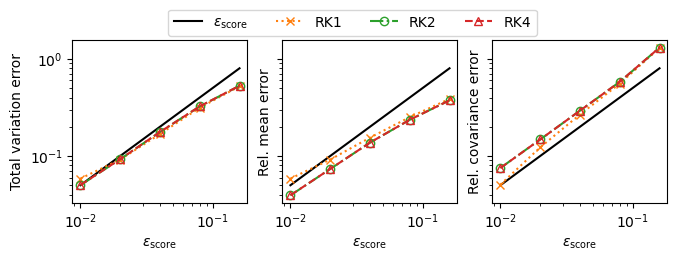

In [40]:
one_dim_delta_test(Ny; seed=111)

[ Info: ("TVes ", [0.09072270309538323 0.17109442712419182 0.3075249575921236 0.4974292253409856; 0.01577890239265945 0.09195469901515978 0.4524592773074147 0.6954654807553385; 0.010895833906114342 0.015825310408004993 0.12549794113216955 0.47739038739918116])
[ Info: ("rmeanes ", [0.04103663285156589 0.07858357049094404 0.1479371424825097 0.26681272446888427; 0.0009331070986496511 0.0034856702648714175 0.010505263386789773 0.013813239720131154; 0.0022073210420914258 0.0010362714535158506 0.0013814825460093754 0.03019573898604211])
[ Info: ("rcoves ", [0.04809508487517579 0.09845960621290648 0.19973019741114814 0.3847188584061873; 0.004089796351765826 0.018412103342802934 0.1008857192463871 0.6228858831752073; 0.0009021696913962654 0.0031849049668960894 0.023350765973439574 0.0870608957305913])


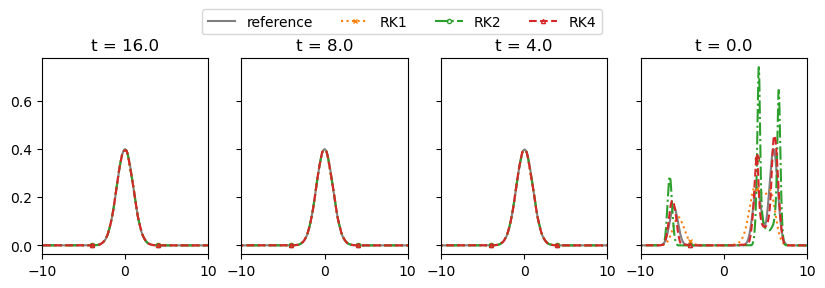

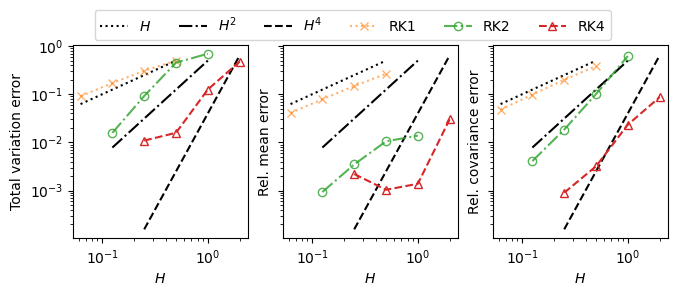

In [41]:
one_dim_test(true, Ny, 1.0e-4; seed=42)  

[ Info: ("TVes ", [0.06324536568659356 0.11555694492498055 0.21129806978315072 0.3622679630676173; 0.013090371264059153 0.0383982629783282 0.1546070407060137 0.574644148126106; 0.011666915718997225 0.01143299940060155 0.03751268303005762 0.3878680816908662])
[ Info: ("rmeanes ", [0.06569992599722137 0.12434278729026065 0.22516464464438357 0.3809134828339161; 0.007080138248720669 0.024124420987252055 0.08472993335283589 0.2791726246399239; 0.0021250214413499613 0.0031042412585214527 0.02426585024778542 0.2756683180135024])
[ Info: ("rcoves ", [0.06730844235198942 0.13149569703710043 0.25383466210273997 0.5291575345777851; 0.011879360037401825 0.0498963336178125 0.19535462535655315 0.6991495994618991; 0.0003643266266229429 0.0028356208708082836 0.04891612605375445 0.6864528927989542])


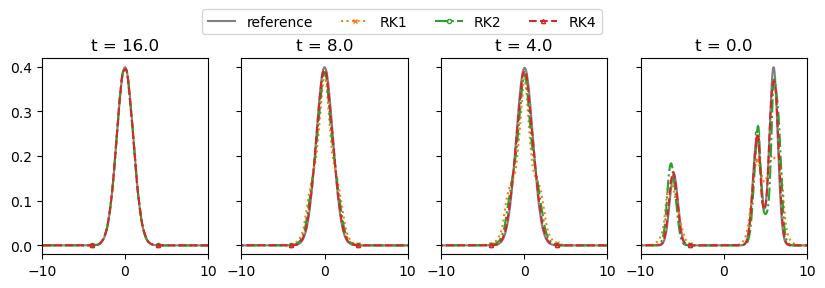

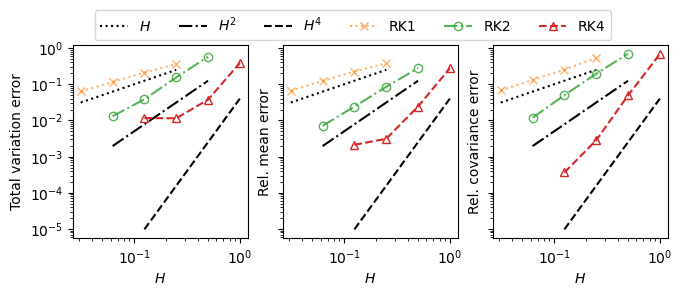

In [42]:
one_dim_test(false, Ny, 1.0e-1; seed=42)

# High dimensional probabilistic flow ODE

## Setup 
We follow the setup in Albergo, Michael S., Nicholas M. Boffi, and Eric Vanden-Eijnden. "Stochastic interpolants: A unifying framework for flows and diffusions." arXiv preprint arXiv:2303.08797 (2023). The target density is a 5-mode Gaussian mixture.


## Kernel reconstruction
We test 1D kernel reconstruction by sampling particles from both the initial and target densities, projecting them onto 1D, and then performing reconstruction.


## Compute: score error and discretization error analysis
We use the RK-p scheme, and conjecture the error is $\mathcal{O}(\Delta t^p + \delta)$, $\delta$ is the score error.
For discretization error analysis, we consider the case with $\delta = 10^{-3}$ (very small).
For score error and discretization error analysis, we consider the case with $\delta = \mathcal{O}(\Delta t^p)$.


- solve the high dimensional probabilistic ODE ($d = 8, 32, 128$)
- reconstruct the 1D marginal density with kernel
- compute different error indicators, including total variation error, mean error and covariance error.

In [36]:
function extract_submatrix(xx_cov_high, dim, cov_diag)
    xx_cov = (cov_diag ? [Diagonal(diag(xx_cov_high[i])[1:dim]) for i = 1:length(xx_cov_high)] : [xx_cov_high[i][1:dim,1:dim] for i = 1:length(xx_cov_high)])
    return xx_cov
end
    
function high_dim_test(δ_fix::Bool, Ny = 40000, δ_ref = 0.0; seed=42)
    Random.seed!(seed)
    
    dim_high = 128
    N_modes = 5
    x_w =  rand(Uniform(0,1), N_modes) 
    x_w = x_w/sum(x_w)
    
    x_mean_high = 3.0*rand(Normal(0, 1), (N_modes, dim_high))
    COV_DIAG = false
    
    xx_cov_high = []
    
    
    for i = 1:N_modes
        if COV_DIAG
            W = rand(Normal(0, 1), (dim_high))
            push!(xx_cov_high, 0.25*(Diagonal(W.*W) + I)/2.0)
        else
            W = rand(Normal(0, 1), (dim_high, dim_high))
            push!(xx_cov_high, 0.25*(W'*W/dim_high + I)/2.0)
        end
    end



    T = 16.0
    dim, x_mean, xx_cov = dim_high, x_mean_high, xx_cov_high 
    GM_mean = x_mean' * x_w 
    GM_cov = zeros(dim, dim)
    for i = 1:N_modes
        GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
    end
    x_l, x_r, Ne = -20, 20, 1000000
    Δx = (x_r - x_l) / Ne
    xx = LinRange(x_l, x_r, Ne + 1)
    xc = (xx[1:Ne] + xx[2:Ne+1])/2.0
    q0 = compute_qt(x_w, x_mean[:, 1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], 0.0, Array(reshape(xc, (Ne, 1))))        
    
 
    # kernel reconstruction
    cbandwidth(t) = (4/(Ny*(1 + 2)))^(1/(1+4)) * (0.5*t/T + 1.0*(1 - t/T)) 
    




    # Setup 
    dims = [8; 32; 128]
    methods = ["RK1",  "RK2",  "RK4"]
    orders = [1.0; 2.0; 4.0]
    Nts = [512 256 128 64;  256 128 64 32;  128 64 32 16] 
    # Nts = [512 256 128 64;  512 256 128 64;  256 128 64 32]
    Nmethod, Nt, Ndim = length(methods), size(Nts,2), length(dims)
    Nsave_ts_ind = 4


    # Store results
    ρ̂Ts = zeros(Nmethod, Nsave_ts_ind, Ne) # marginal density 
    ρ̂T = zeros(Ne) # marginal density 
    TVes = zeros(Ndim, Nmethod, Nt) 
    rmeanes = zeros(Ndim, Nmethod, Nt)   #relative mean error
    rcoves = zeros(Ndim, Nmethod, Nt)    #relative covariance error


    # Initial condition
    Y0_high = rand(Normal(0, 1), (Ny, dim_high))
    Y0 = Y0_high 

    
    Ys = zeros(Nsave_ts_ind, Ny, dims[end]) 
    for idim = 1:Ndim
        dim = dims[idim]
        x_mean = x_mean_high[:, 1:dim]
        xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
        Y0 = Y0_high[:, 1:dim]
        # reference
        GM_mean = x_mean' * x_w 
        GM_cov = zeros(dim, dim)
        for i = 1:N_modes
            GM_cov += x_w[i] * (xx_cov[i] + (x_mean[i,:] - GM_mean)*(x_mean[i,:] - GM_mean)')
        end
        for imethod = 1:Nmethod
            for it = 1:Nt 
                @info dim, methods[imethod], Nts[imethod, it]
                δ = (δ_fix ? δ_ref : δ_ref*(Nts[imethod,end]/Nts[imethod,it])^orders[imethod]) # maxmimum error is δ_ref
                ts = LinRange(0, T, Nts[imethod, it]+1)
                save_ts_ind = [0; div(Nts[imethod, it],2); 3*div(Nts[imethod, it],4); Nts[imethod, it]]
                compute_V(t, xx) = compute_U_GM(x_w, x_mean, xx_cov, t, T, xx) + score_error(δ, (ndims(xx) == 1 ? Array(reshape(xx, (length(xx), 1))) : xx) )
                Ys[:, :, 1:dim], _ = solve(T, Nts[imethod, it], Y0, compute_V; ts=ts, save_ts_ind=save_ts_ind, method=methods[imethod]) 
            
            
    
                kernel = kde(Ys[end, :,1], bandwidth=cbandwidth(T)) #project to the first component
                ρ̂T[:] = pdf(kernel, xc)
                TVes[idim, imethod, it]   = sum(abs.(ρ̂T - q0)) / 2.0 * (xc[2] - xc[1])
                GM_mean_esti = sum(Ys[end, :,1:dim], dims=1)[:]/Ny
                rmeanes[idim, imethod, it] = norm(GM_mean_esti - GM_mean) / norm(GM_mean)
                rcoves[idim, imethod, it]  = norm((Ys[end, :,1:dim] - ones(Ny)*GM_mean_esti')'*(Ys[end, :,1:dim] - ones(Ny)*GM_mean_esti')/Ny - GM_cov) / norm(GM_cov)
    


                
                if idim == Ndim && it == Nt # store results for visualization
                    for i = 1:Nsave_ts_ind
                        kernel = kde(Ys[i, :, 1], bandwidth=cbandwidth(ts[i]))
                        ρ̂Ts[imethod, i, :] = pdf(kernel, xc)
                    end
                end

                
            end
        end
    end



    # plot marginal for 128 dimensional problem
    ncols = 4
    markers = ["x"; "o"; "^"]  
    linestyles = ["dotted"; "dashdot"; "--"]
    alphas =[0.6; 0.8; 1.0]
    labels = ["RK1", "RK2", "RK4"]
    idim = 3 
    dim = dims[idim]
    x_mean = x_mean_high[:, 1:dim]
    xx_cov = extract_submatrix(xx_cov_high, dim, COV_DIAG)
    Y0 = Y0_high[:, 1:dim]
    
    ts = [T; T/2; T/4; 0.0]
    fig, ax = PyPlot.subplots(ncols=ncols, sharex=true, sharey="row", figsize=(9, 2.8))
    
    ## plot reference at different time
    for i  = 1:ncols
        t = ts[i]
        qt = compute_qt(x_w, x_mean[:,1:1], [xx_cov[i][1:1,1:1] for i = 1:N_modes], t, Array(reshape(xc, (Ne, 1))))
    
        ax[i].plot(xc, qt,   "-", color = "grey", fillstyle="none", label="reference")
        ax[i].title.set_text("t = "*string(t))
    
    end
    # marginal 
    for imethod = 1:Nmethod
        for i  = 1:ncols
            t = ts[i]
            ρ̂t = ρ̂Ts[imethod, i, :]
            ax[i].plot(xc, ρ̂t, linestyle=linestyles[imethod], marker=markers[imethod], color = "C"*string(imethod), fillstyle="none", markevery=div(Ne, 10), markersize = 3, label=labels[imethod])
            ax[i].set_xlim([-10.,10.])
        end
    end
    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncol=4)
    fig.subplots_adjust(bottom=0.1,top=0.80,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("high-D-ode-density"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))



    
    labels = ["RK1", "RK2", "RK4"]
    hs = T ./ Nts
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=true, sharey=true, figsize=(7, 3.3))
    for i = 1:3
        ax[i].loglog(hs[1,:], hs[1,:].^1, linestyle="dotted", color = "black", fillstyle="none", label=L"H")
        ax[i].loglog(hs[2,:], 0.5*hs[2,:].^2, linestyle="dashdot", color = "black", fillstyle="none", label=L"H^2")
        ax[i].loglog(hs[3,:], 0.1*hs[3,:].^4, linestyle="--", color = "black", fillstyle="none", label=L"H^4")
    end
    linestyles = ["dotted"; "dashdot"; "--"]
    alphas =[0.6; 0.8; 1.0]
    for imethod = 1:Nmethod
        for idim = 1:Ndim
            label = ( imethod == Nmethod ? methods[imethod]*" (d = "* string(dims[idim]) * ")" : methods[imethod])
            ax[1].loglog(hs[imethod,:], TVes[idim, imethod, :],    linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string(idim), alpha =alphas[idim], fillstyle="none", label = label)  
            ax[2].loglog(hs[imethod,:], rmeanes[idim, imethod, :], linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string(idim), alpha =alphas[idim], fillstyle="none", label = label)  
            ax[3].loglog(hs[imethod,:], rcoves[idim, imethod, :],  linestyle=linestyles[imethod], marker=markers[idim], color = "C"*string(idim), alpha =alphas[idim], fillstyle="none", label = label)  
        end
    end
    for i = 1:3
        ax[i].set_xlabel(L"H");
        ax[i].set_xticks([0.1 ; 1.0]) 
    end
    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,1.0),ncols=4)
    ax[1].set_ylabel("Total variation error")
    ax[2].set_ylabel("Rel. mean error")
    ax[3].set_ylabel("Rel. covariance error")
    fig.subplots_adjust(bottom=0.16,top=0.70,left=0.1,right=0.95,hspace=0.2)
    fig.savefig("high-D-ode-error"*(δ_fix ? "(discretization-error).pdf" : "(total-error).pdf"))
end

high_dim_test (generic function with 3 methods)

[ Info: (8, "RK1", 512)
[ Info: (8, "RK1", 256)
[ Info: (8, "RK1", 128)
[ Info: (8, "RK1", 64)
[ Info: (8, "RK2", 256)
[ Info: (8, "RK2", 128)
[ Info: (8, "RK2", 64)
[ Info: (8, "RK2", 32)
[ Info: (8, "RK4", 128)
[ Info: (8, "RK4", 64)
[ Info: (8, "RK4", 32)
[ Info: (8, "RK4", 16)
[ Info: (32, "RK1", 512)
[ Info: (32, "RK1", 256)
[ Info: (32, "RK1", 128)
[ Info: (32, "RK1", 64)
[ Info: (32, "RK2", 256)
[ Info: (32, "RK2", 128)
[ Info: (32, "RK2", 64)
[ Info: (32, "RK2", 32)
[ Info: (32, "RK4", 128)
[ Info: (32, "RK4", 64)
[ Info: (32, "RK4", 32)
[ Info: (32, "RK4", 16)
[ Info: (128, "RK1", 512)
[ Info: (128, "RK1", 256)
[ Info: (128, "RK1", 128)
[ Info: (128, "RK1", 64)
[ Info: (128, "RK2", 256)
[ Info: (128, "RK2", 128)
[ Info: (128, "RK2", 64)
[ Info: (128, "RK2", 32)
[ Info: (128, "RK4", 128)
[ Info: (128, "RK4", 64)
[ Info: (128, "RK4", 32)
[ Info: (128, "RK4", 16)


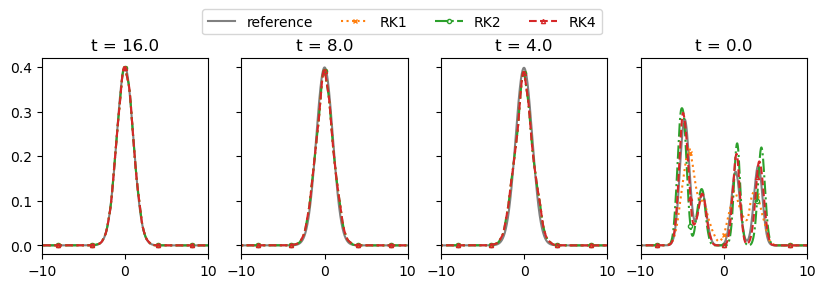

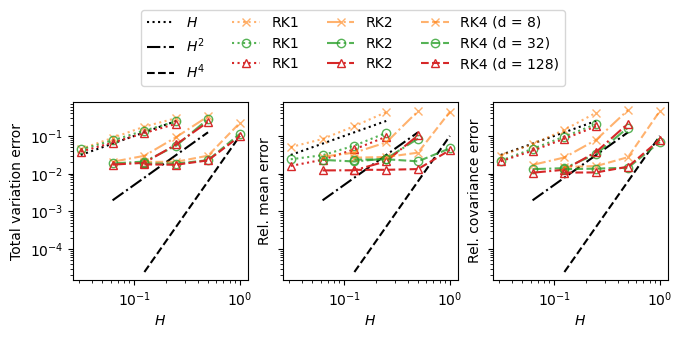

In [37]:
high_dim_test(false, 10000, 2.0e-1; seed=42)